In [28]:
import os

os.chdir("/home/tales/dev/master/mdc_analysis/")
print("working dir", os.getcwd())

import pandas as pd
import matplotlib.pyplot as plt

import gc
from src.dao import csv_dao
from src.plot import plot
from src.utils import geo

from bokeh.io import output_notebook, show
output_notebook()

pd.set_option('display.float_format', lambda x: '%.4f' % x)

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

working dir /home/tales/dev/master/mdc_analysis


Loading BokehJS ...

# Stop Region nearest POIs 

## Loading

In [36]:
def valid_amenities(pois):
    return pois[pois["amenity"].isna() == False]

def unique_stop_regions(knn_pois):
    unique_sr = knn_pois.drop_duplicates(subset=["lat_sr", "lon_sr"], keep="first")["sr_id"].tolist()
    return knn_pois[knn_pois["sr_id"].isin(unique_sr)]

def load_sr_knn_pois_for_all_users():
    users = csv_dao.list_stop_region_usernames()
    knn_pois = pd.DataFrame()
    
    for user in users:
        print("user_id: {}".format(user))
        try:
            user_knn_pois = csv_dao.load_sr_distance_to_close_pois(user)
            #print("User {} data loaded".format(user))
        except FileNotFoundError:
            continue
            
        user_knn_pois["user"] = user
        knn_pois = knn_pois.append(user_knn_pois)
    print("done!")
    return knn_pois

In [37]:
sr_knn_pois = load_sr_knn_pois_for_all_users()
print("All Stop Regions:    {}".format(len(sr_knn_pois["sr_id"].drop_duplicates())))
unique_sr_knn_pois = unique_stop_regions(sr_knn_pois)
print("Unique Stop Regions: {}".format(len(unique_sr_knn_pois["sr_id"].drop_duplicates())))

unique_sr_knn_pois.sample(6)

user_id: 6189
user_id: 5936
user_id: 6087
user_id: 5973
user_id: 6085
user_id: 6074
user_id: 6012
user_id: 5982
user_id: 5948
user_id: 5974
user_id: 6090
user_id: 6199
user_id: 6068
user_id: 6024
user_id: 5976
user_id: 6094
user_id: 5941
user_id: 5995
user_id: 5962
user_id: 6093
user_id: 6033
user_id: 6079
user_id: 6038
user_id: 6175
user_id: 6042
user_id: 5924
user_id: 6083
user_id: 6178
user_id: 5958
user_id: 6086
user_id: 6100
user_id: 5945
user_id: 5925
user_id: 5935
user_id: 6172
user_id: 5955
user_id: 6073
user_id: 5980
user_id: 6010
user_id: 5993
user_id: 6037
user_id: 5979
user_id: 5966
user_id: 5985
user_id: 5967
user_id: 5970
user_id: 6169
user_id: 6188
user_id: 6097
user_id: 6096
user_id: 6041
user_id: 6192
user_id: 6064
user_id: 6183
user_id: 5954
user_id: 5972
user_id: 6060
user_id: 6069
user_id: 5937
user_id: 6028
user_id: 5990
user_id: 6071
user_id: 5928
user_id: 5992
user_id: 6058
user_id: 6001
user_id: 5964
user_id: 5950
user_id: 5991
user_id: 6177
user_id: 5961
user_i

,distance,osm_id,lat_sr,lon_sr,sr_id,position,user
8,183.1035,2481370770,46.5282,6.6023,6003_73,8,6003
6,284.0144,2776732754,46.5251,6.5660,5993_2786,6,5993
27,811.3817,901414507,46.5337,6.6192,5995_343,27,5995
0,100.4437,2469119721,46.5314,6.5982,6002_64,0,6002
0,8.0211,285904099,46.8630,7.3626,6175_276,0,6175
9,476.3384,6007413407,46.5330,6.5640,6069_5,9,6069


In [38]:
pois = csv_dao.load_hot_osm_pois()
valid_pois = valid_amenities(pois)

valid_pois.sample(6)

,osm_id,amenity,name,place,latitude,longitude,SRID,lon_4326,lat_4326
277524,1435363467,restaurant,Schöntal,NaN,1011309.2100,6052389.9800,900913,9.0847,47.6716
211482,5852230326,toilets,NaN,NaN,1054069.5200,5815479.6900,900913,9.4689,46.2188
33960,5360433261,pharmacy,Coop Vitality,NaN,731358.3600,5868037.5200,900913,6.5699,46.5445
185605,2408003889,restaurant,Apithai,NaN,924222.7800,6021324.4700,900913,8.3024,47.4833
43036,292179540,restaurant,Ciao Ciao,NaN,739655.7900,5906288.1100,900913,6.6444,46.7803
41773,432607566,restaurant,El Tostador,NaN,706325.3300,5926838.2700,900913,6.3450,46.9066


## Merging dataframes

In [39]:
unique_sr_knn_pois = unique_sr_knn_pois.merge(valid_pois[["osm_id", "amenity", "lat_4326", "lon_4326"]], how="inner", on="osm_id")
unique_sr_knn_pois.sort_values(by=["sr_id", "position"]).head()

,distance,osm_id,lat_sr,lon_sr,sr_id,position,user,amenity,lat_4326,lon_4326
1122003,36.6693,1128531574,46.2920,7.5326,5924_100,0,5924,restaurant,46.2923,7.5325
1121217,54.6971,5491540912,46.2920,7.5326,5924_100,1,5924,post_office,46.2922,7.5320
1120813,65.7970,2426800894,46.2920,7.5326,5924_100,2,5924,atm,46.2921,7.5318
1574446,72.0449,2068948263,46.2920,7.5326,5924_100,3,5924,toilets,46.2924,7.5334
1122385,81.8783,2426800869,46.2920,7.5326,5924_100,4,5924,atm,46.2927,7.5321


## Removing Home and Work Stop Regions

In [40]:
# def remove_home_and_work_sr(data):
    
#     for user_id in users = csv_dao.list_stop_region_usernames():
#         home_sr_ids = csv_dao.load_home_inferred_sr_ids()
#         work_sr_ids = csv_dao.load_work_inferred_sr_ids()

#     return data[~data["sr_id"].isin(home_sr_ids + work_sr_ids)]

In [41]:
# print(len(unique_sr_knn_pois))
# unique_sr_knn_pois = remove_home_and_work_sr(unique_sr_knn_pois)
# print(len(unique_sr_knn_pois))

## How far to the Stop Regions are the POIs?

In [42]:
home_and_work = []
for user_id in unique_sr_knn_pois["user"].drop_duplicates().tolist():
    home_and_work = home_and_work + csv_dao.load_home_inferred_sr_ids(user_id) + csv_dao.load_work_inferred_sr_ids(user_id)

In [43]:
home_and_work_sr_knn_pois = unique_sr_knn_pois[unique_sr_knn_pois["sr_id"].isin(home_and_work)]
unique_sr_knn_pois = unique_sr_knn_pois[~unique_sr_knn_pois["sr_id"].isin(home_and_work)]
gc.collect()

1085

In [44]:
print("HOME and WORK stop regions")
print(len(home_and_work_sr_knn_pois), "rows")
home_and_work_sr_knn_pois.sample(6)

HOME and WORK stop regions
483692 rows


,distance,osm_id,lat_sr,lon_sr,sr_id,position,user,amenity,lat_4326,lon_4326
933671,588.1799,334500412,46.5252,6.5659,5993_2174,22,5993,restaurant,46.5203,6.5688
1614746,1513.8556,2112354952,46.5700,6.5500,6004_742,5,6004,library,46.5789,6.5350
567612,93.8804,2701144518,46.5240,6.5650,5927_3041,1,5927,pharmacy,46.5232,6.5654
1388726,2842.5976,3098514356,46.2764,6.9335,5928_1932,22,5928,restaurant,46.2532,6.9492
695009,764.6542,2712805865,46.0943,7.0683,6051_168,19,6051,restaurant,46.0995,7.0747
1500524,5491.6005,5316593745,46.5095,6.3114,5940_522,25,5940,pharmacy,46.4628,6.3350


In [45]:
print("Other stop regions")
print(len(unique_sr_knn_pois), "rows")
unique_sr_knn_pois.sample(6)

Other stop regions
1461154 rows


,distance,osm_id,lat_sr,lon_sr,sr_id,position,user,amenity,lat_4326,lon_4326
304355,702.8872,4493047807,46.5377,6.6321,5959_1607,19,5959,bus_station,46.5366,6.6231
518187,456.5727,4304424760,46.5284,6.5991,6094_58,12,6094,fast_food,46.5279,6.6050
1847556,5461.2674,1625568232,46.5091,6.3115,5940_137,26,5940,restaurant,46.4629,6.3357
1425513,1555.8026,1096763458,46.1266,7.1264,6028_11,15,6028,toilets,46.1376,7.1140
1480499,3439.3070,291545422,46.3124,7.3857,5965_1158,7,5965,toilets,46.2816,7.3821
85414,641.9527,4940980165,46.5144,6.6542,5974_910,21,5974,toilets,46.5167,6.6619


In [48]:
firsts = pd.DataFrame()
seconds = pd.DataFrame()
thirds = pd.DataFrame()
for sr_id in unique_sr_knn_pois["sr_id"].drop_duplicates():
    sr_knn = unique_sr_knn_pois[unique_sr_knn_pois["sr_id"] == sr_id]
    
    firsts = firsts.append(sr_knn[sr_knn["position"] == 0])
    seconds = seconds.append(sr_knn[sr_knn["position"] == 1])
    thirds = thirds.append(sr_knn[sr_knn["position"] == 2])    

In [49]:
firsts["distance"].describe()

count   49721.0000
mean      354.1428
std       544.0410
min         0.0000
25%        49.7681
50%       166.8099
75%       455.0727
max     21135.2089
Name: distance, dtype: float64

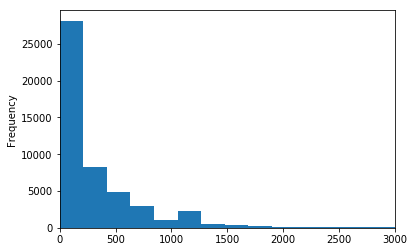

In [50]:
firsts["distance"].plot.hist(xlim=(0, 3000), bins=100)

In [51]:
seconds["distance"].describe()

count   49654.0000
mean      494.2382
std       694.0525
min         1.4080
25%        86.0738
50%       241.1914
75%       616.4742
max     21316.6473
Name: distance, dtype: float64

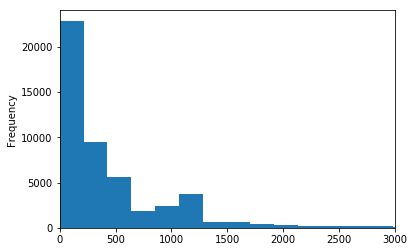

In [52]:
seconds["distance"].plot.hist(xlim=(0, 3000), bins=100)

In [53]:
thirds["distance"].describe()

count   49560.0000
mean      622.8386
std       835.2948
min         1.4080
25%       116.4058
50%       301.4332
75%       767.7155
max     21391.4264
Name: distance, dtype: float64

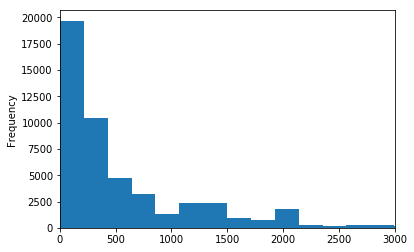

In [54]:
thirds["distance"].plot.hist(xlim=(0, 3000), bins=100)

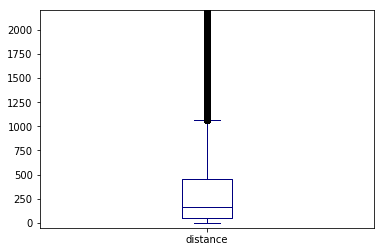

In [55]:
firsts["distance"].plot.box(ylim=(-50,2200), color="navy")

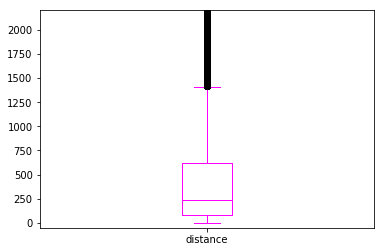

In [56]:
seconds["distance"].plot.box(ylim=(-50,2200), color="magenta")

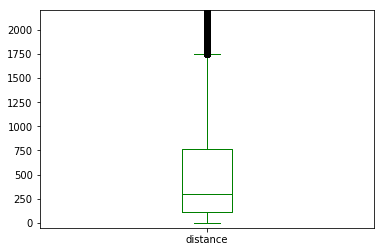

In [57]:
thirds["distance"].plot.box(ylim=(-50,2200), color="green")

## Closer POIs frequency of amenities

tipo lugar que o cara costuma frequentar... :)

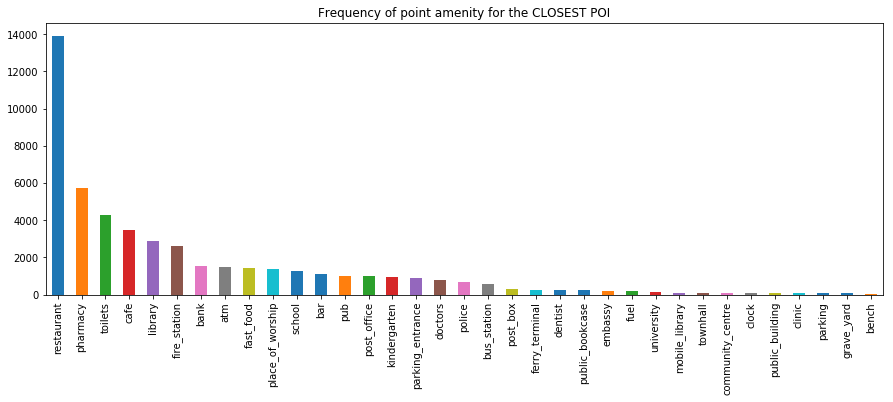

In [58]:
f, ax = plt.subplots(figsize=(15,5))
firsts["amenity"].value_counts().head(35).plot.bar(title="Frequency of point amenity for the CLOSEST POI")

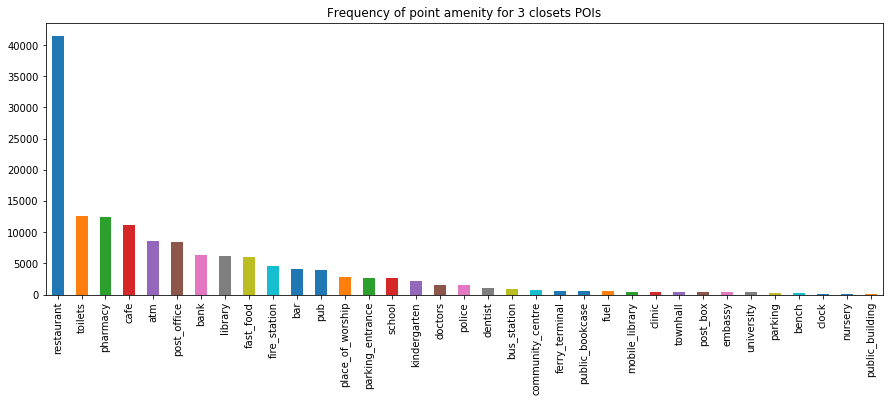

In [59]:
f, ax = plt.subplots(figsize=(15,5))
firsts.append(seconds).append(thirds)["amenity"].value_counts().head(35).plot.bar(title="Frequency of point amenity for 3 closets POIs")

## Variety of closer POIs

In [60]:
max_distance = 500
most_common_frequency = []
len_close_pois = []

for sr_id in unique_sr_knn_pois["sr_id"].drop_duplicates():
    knn_pois = unique_sr_knn_pois[unique_sr_knn_pois["sr_id"] == sr_id]
    use_knn_pois = knn_pois[knn_pois["distance"] <= max_distance]
    
    len_close_pois.append(len(use_knn_pois))
    
    if len(use_knn_pois) == 0:
        continue    
    most_common_frequency.append(use_knn_pois["amenity"].value_counts(normalize=True).iloc[0])

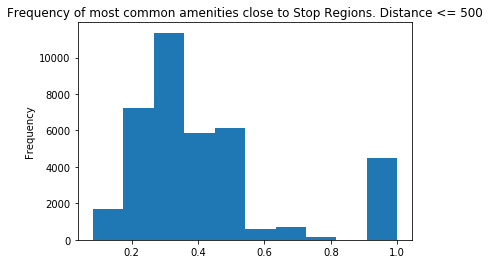

In [61]:
pd.Series(most_common_frequency).plot.hist(title="Frequency of most common amenities close to Stop Regions. Distance <= {}".format(max_distance))

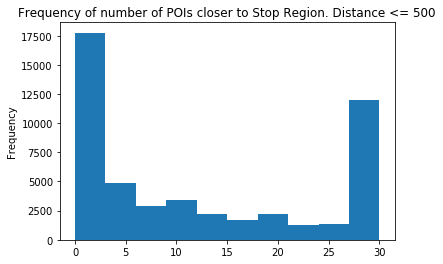

In [62]:
pd.Series(len_close_pois).plot.hist(title="Frequency of number of POIs closer to Stop Region. Distance <= {}".format(max_distance))

## Plotting Close Neighbors

In [63]:
user = pd.Series(csv_dao.list_stop_region_usernames()).sample().item()
print("User: {}".format(user))
unique_sr_knn_pois[unique_sr_knn_pois["user"] == user].sort_values(by=["sr_id", "position"]).head(10)

User: 6066


,distance,osm_id,lat_sr,lon_sr,sr_id,position,user,amenity,lat_4326,lon_4326
356298,84.2824,434359623,46.2205,7.0190,6066_0,0,6066,school,46.2205,7.0179
357304,85.9620,1314641007,46.2205,7.0190,6066_0,1,6066,fire_station,46.2207,7.0180
355494,175.1899,434359627,46.2205,7.0190,6066_0,2,6066,post_office,46.2201,7.0168
1238595,1104.1160,2488703274,46.2205,7.0190,6066_0,3,6066,pub,46.2205,7.0047
375791,1105.5340,2488745373,46.2205,7.0190,6066_0,4,6066,pub,46.2198,7.0047
377396,1116.5957,2488705764,46.2205,7.0190,6066_0,5,6066,post_box,46.2201,7.0046
374926,1122.0891,2488762244,46.2205,7.0190,6066_0,6,6066,restaurant,46.2196,7.0046
1239369,1124.3485,2488711561,46.2205,7.0190,6066_0,7,6066,restaurant,46.2203,7.0045
1240122,1131.1063,2488703267,46.2205,7.0190,6066_0,8,6066,cafe,46.2205,7.0044
367308,1132.5879,2952055634,46.2205,7.0190,6066_0,9,6066,pub,46.2184,7.0047


In [64]:
p = None
user_unique_sr_knn_pois = unique_sr_knn_pois[unique_sr_knn_pois["user"] == user]

print("{} Stop Regions".format(len(user_unique_sr_knn_pois[["lat_sr", "lon_sr"]].drop_duplicates())))
p = plot.plot_stop_regions_centroids(user_unique_sr_knn_pois[["lat_sr", "lon_sr"]].drop_duplicates(), 
                                     fill_color="navy", title="User {} Stop Regions and POIs".format(user_unique_sr_knn_pois["user"].tolist()[0]), lat_col="lat_sr", lon_col="lon_sr",
                                    width=700, height=500)

print("{} Close POIs".format(len(user_unique_sr_knn_pois)))
p = plot.plot_poi(user_unique_sr_knn_pois, lat_col="lat_4326", lon_col="lon_4326", title="", 
                      figure=p, width=700, height=500, color="green")

show(p)

410 Stop Regions
11893 Close POIs


In [65]:
firsts[firsts["user"] == user]["distance"].describe()

count    410.0000
mean     239.5604
std      372.4548
min        3.1278
25%      160.4457
50%      174.6575
75%      194.2310
max     3242.6018
Name: distance, dtype: float64

## Plot Isolated Stop Regions